In [164]:
from scipy.ndimage import convolve
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [165]:
def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [166]:
def sobel_filters(img):
    gx = np.zeros((len(img),len(img[0])))
    gy = np.zeros((len(img),len(img[0])))
    g = np.zeros((len(img),len(img[0])))
    theta = np.zeros((len(img),len(img[0])))

    for i in range(1, len(img)-1): # Height
        for j in range(1, len(img[0]) - 1): # Width
            gx[i][j] = (img[i - 1][j - 1] + 2*img[i][j - 1] + img[i + 1][j - 1]) - (img[i - 1][j + 1] + 2*img[i][j + 1] + img[i +
                        1][j + 1])
            gy[i][j] = (img[i - 1][j - 1] + 2*img[i - 1][j] + img[i - 1][j + 1]) - (img[i + 1][j - 1] + 2*img[i + 1][j] + img[i +
                        1][j + 1])
            g[i][j] = min(255, np.sqrt(gx[i][j]**2 + gy[i][j]**2))
            theta[i][j] = np.arctan2(gy[i][j], gx[i][j])

    return (g, theta)

In [167]:
#This cell contains all functions used in Phase 2

#2.a : Find closest direction D*
def closest_dir_function(grad_dir) :
    closest_dir_arr = np.zeros(grad_dir.shape)
    for i in range(1, int(grad_dir.shape[0] - 1)) :
        for j in range(1, int(grad_dir.shape[1] - 1)) :
            
            if((grad_dir[i, j] > -22.5 and grad_dir[i, j] <= 22.5) or (grad_dir[i, j] <= -157.5 and grad_dir[i, j] > 157.5)) :
                closest_dir_arr[i, j] = 0
                
            elif((grad_dir[i, j] > 22.5 and grad_dir[i, j] <= 67.5) or (grad_dir[i, j] <= -112.5 and grad_dir[i, j] > -157.5)) :
                closest_dir_arr[i, j] = 45
                
            elif((grad_dir[i, j] > 67.5 and grad_dir[i, j] <= 112.5) or (grad_dir[i, j] <= -67.5 and grad_dir[i, j] > -112.5)) : 
                closest_dir_arr[i, j] = 90
                
            else:
                closest_dir_arr[i, j] = 135
                
    return closest_dir_arr


#2.b : Convert to thinned edge
def non_maximal_suppressor(grad_mag, closest_dir) :
    thinned_output = np.zeros(grad_mag.shape)
    for i in range(1, int(grad_mag.shape[0] - 1)) :
        for j in range(1, int(grad_mag.shape[1] - 1)) :
            
            if(closest_dir[i, j] == 0) :
                if((grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 45) :
                if((grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 90) :
                if((grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            else :
                if((grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
    return thinned_output/np.max(thinned_output)   


In [168]:
#This cell contains all the used functionsfor Phase III

#Function to include weak pixels that are connected to chain of strong pixels 
def DFS(img) :
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] == 1) :
                t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                            img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                if(t_max == 2) :
                    img[i, j] = 2
                
                    
#Hysteresis Thresholding
def hysteresis_thresholding(img) :
    low_ratio = 0.10
    high_ratio = 0.30
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff
    
    temp_img = np.copy(img)
    
    #Assign values to pixels
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            #Strong pixels
            if(img[i, j] > t_high) :
                temp_img[i, j] = 2
            #Weak pixels
            elif(img[i, j] < t_low) :
                temp_img[i, j] = 0
            #Intermediate pixels
            else :
                temp_img[i, j] = 1
    
    #Include weak pixels that are connected to chain of strong pixels 
    total_strong = np.sum(temp_img == 2)
    while(1) :
        DFS(temp_img)
        if(total_strong == np.sum(temp_img == 2)) :
            break
        total_strong = np.sum(temp_img == 2)
    
    #Remove weak pixels
    for i in range(1, int(temp_img.shape[0] - 1)) :
        for j in range(1, int(temp_img.shape[1] - 1)) :
            if(temp_img[i, j] == 1) :
                temp_img[i, j] = 0
    
    temp_img = temp_img/np.max(temp_img)
    return temp_img    

(-0.5, 399.5, 299.5, -0.5)

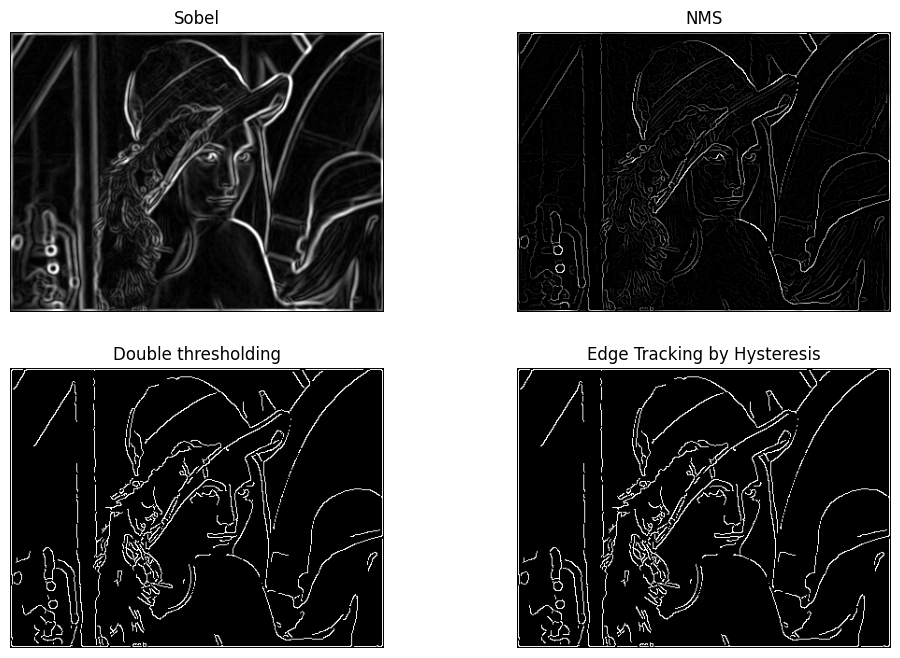

In [169]:
img = Image.open("data/lena.jpg")
img = img.convert("L")
img = np.array(img)

img_filtered = convolve(img, gaussian_kernel(5, sigma=1.4))
grad, theta = sobel_filters(img_filtered)
closest_dir = closest_dir_function(np.degrees(theta))
img_nms = non_maximal_suppressor(grad, closest_dir)
output_img = hysteresis_thresholding(img_nms)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(grad, cmap='gray')
plt.title("Sobel")
plt.axis('off')

plt.subplot(222)
plt.imshow(img_nms, cmap='gray')
plt.title("NMS")
plt.axis('off')

plt.subplot(223)
plt.imshow(img_thresh, cmap='gray')
plt.title("Double thresholding")
plt.axis('off')

plt.subplot(224)
plt.imshow(output_img, cmap='gray')
plt.title("Edge Tracking by Hysteresis")
plt.axis('off')
